In [1]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('Text Classification').getOrCreate()
cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print(f'Cores working: {cores}')
spark

Cores working: 1


In [4]:
df = (spark.read
      .format('csv')
      .option('header', 'true')
      .option('inferSchema', 'true')
      .load('./data/udemy_courses_clean.csv'))

In [6]:
df.limit(2).toPandas()

,_c0,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,clean_course_title
0,0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5 hours,2017-01-18T20:58:58Z,Business Finance,Ultimate Investment Banking Course
1,1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39 hours,2017-03-09T16:34:20Z,Business Finance,Complete GST Course Certification Grow Practice


In [7]:
print(df.columns)

['_c0', 'course_id', 'course_title', 'url', 'is_paid', 'price', 'num_subscribers', 'num_reviews', 'num_lectures', 'level', 'content_duration', 'published_timestamp', 'subject', 'clean_course_title']


In [9]:
text = df.select('course_title', 'subject')

In [10]:
text.show(5)

+--------------------+----------------+
|        course_title|         subject|
+--------------------+----------------+
|Ultimate Investme...|Business Finance|
|Complete GST Cour...|Business Finance|
|Financial Modelin...|Business Finance|
|Beginner to Pro -...|Business Finance|
|How To Maximize Y...|Business Finance|
+--------------------+----------------+
only showing top 5 rows



In [14]:
text.groupBy('subject').count().show()

+--------------------+-----+
|             subject|count|
+--------------------+-----+
|play Electric Gui...|    1|
|Multiply returns ...|    1|
|                null|    6|
|    Business Finance| 1198|
|Introduction Guit...|    1|
|Learn Play Fernan...|    1|
|      Graphic Design|  603|
|Aprende tocar el ...|    1|
|     Web Development| 1200|
|Learn Classical G...|    1|
| Musical Instruments|  676|
+--------------------+-----+



In [15]:
text.toPandas().isna().sum()

course_title    0
subject         6
dtype: int64

In [16]:
text = text.dropna(subset=('subject'))

In [17]:
text.toPandas().isna().sum()

course_title    0
subject         0
dtype: int64

In [18]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover,IDF,CountVectorizer

In [19]:
tokenizer = Tokenizer(inputCol= 'course_title', outputCol= 'tokens')
stop_w_r = StopWordsRemover(inputCol= 'tokens', outputCol= 'stp_tokens')
vectorizer = CountVectorizer(inputCol= 'stp_tokens', outputCol= 'vectors')
idf = IDF(inputCol= 'vectors', outputCol= 'vectorized')

In [20]:
from pyspark.ml.feature import StringIndexer

In [21]:
lbl_encoder = StringIndexer(inputCol= 'subject', outputCol= 'label').fit(text)

In [22]:
tranformer = lbl_encoder.transform(text)

In [25]:
tranformer.show(5)

+--------------------+----------------+-----+
|        course_title|         subject|label|
+--------------------+----------------+-----+
|Ultimate Investme...|Business Finance|  1.0|
|Complete GST Cour...|Business Finance|  1.0|
|Financial Modelin...|Business Finance|  1.0|
|Beginner to Pro -...|Business Finance|  1.0|
|How To Maximize Y...|Business Finance|  1.0|
+--------------------+----------------+-----+
only showing top 5 rows



In [29]:
lbl_encoder.labels

['Web Development',
 'Business Finance',
 'Musical Instruments',
 'Graphic Design',
 'Aprende tocar el Acorden de odo con tcnicahttpswwwudemycomaprendeatocarelacordeondeoidoycontecnicatrue25932134Beginner Level4 hours20140916T195145Z 263432Aprende los Secretos de la Armnica con HARPSOUL',
 'Introduction Guitar A Course Beginnershttpswwwudemycomintroductiontoguitartrue251631156Beginner Level25 hours20141030T155939Z 650804Guitar Master Class Learning Play Guitar Z',
 'Learn Classical Guitar Technique play Spanish Romancehttpswwwudemycomguitartechniquestrue19513164643All Levels5 hours20131118T175959Z 265888Learn Guitar Worship Learn 4 Songs unlock 1',
 'Learn Play Fernando Sors Study B minorhttpswwwudemycomstudyinbminortrue115140359Intermediate Level43 mins20140127T205816Z 398746Piano Chord Based System  Learn Play Pros Do',
 'Multiply returns Value Investinghttpswwwudemycommultiplyyourreturnsusingvalueinvestingtrue2019421963All Levels45 hours20150723T000833Z 874284Weekly Forex Analysis B

In [30]:
lbl_dict = {
    'Web Development': 0.0,
     'Business Finance': 1.0,
     'Musical Instruments': 2.0,
     'Graphic Design': 3.0,
     'Aprende tocar el Acorden de odo con tcnicahttpswwwudemycomaprendeatocarelacordeondeoidoycontecnicatrue25932134Beginner Level4 hours20140916T195145Z 263432Aprende los Secretos de la Armnica con HARPSOUL': 4.0,
     'Introduction Guitar A Course Beginnershttpswwwudemycomintroductiontoguitartrue251631156Beginner Level25 hours20141030T155939Z 650804Guitar Master Class Learning Play Guitar Z': 5.0,
     'Learn Classical Guitar Technique play Spanish Romancehttpswwwudemycomguitartechniquestrue19513164643All Levels5 hours20131118T175959Z 265888Learn Guitar Worship Learn 4 Songs unlock 1': 6.0,
     'Learn Play Fernando Sors Study B minorhttpswwwudemycomstudyinbminortrue115140359Intermediate Level43 mins20140127T205816Z 398746Piano Chord Based System  Learn Play Pros Do': 7.0,
     'Multiply returns Value Investinghttpswwwudemycommultiplyyourreturnsusingvalueinvestingtrue2019421963All Levels45 hours20150723T000833Z 874284Weekly Forex Analysis Baraq FX': 8.0,
     'play Electric Guitarhttpswwwudemycomelectricguitarbeginnersmethodtrue501105520Beginner Level2 hours20161229T002406Z 42038Learn Piano Today Play Piano Course Quick Lessons': 9.0
}

In [31]:
xTrain, xTest = tranformer.randomSplit((0.7, 0.3), seed= 42)

In [32]:
xTrain.count()

2631

In [33]:
xTest.show(5)

+--------------------+-------------------+-----+
|        course_title|            subject|label|
+--------------------+-------------------+-----+
|#12 Hand Coordina...|Musical Instruments|  2.0|
|#7 Piano Hand Coo...|Musical Instruments|  2.0|
|'Greensleeves' Cr...|Musical Instruments|  2.0|
|* An Integrated A...|   Business Finance|  1.0|
|         1 Hour HTML|    Web Development|  0.0|
+--------------------+-------------------+-----+
only showing top 5 rows



In [34]:
from pyspark.ml.classification import LogisticRegression

In [35]:
lr = LogisticRegression(featuresCol= 'vectorized', labelCol= 'label')

In [36]:
from pyspark.ml import Pipeline

In [37]:
pipeline = Pipeline(stages= [tokenizer, stop_w_r, vectorizer, idf, lr])

In [39]:
pipeline.stages

Param(parent='Pipeline_0e81546bf041', name='stages', doc='a list of pipeline stages')

In [40]:
lr_model = pipeline.fit(xTrain)

In [42]:
preictions = lr_model.transform(xTest)

In [45]:
preictions.limit(5).toPandas()

,course_title,subject,label,tokens,stp_tokens,vectors,vectorized,rawPrediction,probability,prediction
0,#12 Hand Coordination: Let your Hands dance wi...,Musical Instruments,2.0,"[#12, hand, coordination:, let, your, hands, d...","[#12, hand, coordination:, let, hands, dance, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.22575678848105, 3.5975679171861135, 6.34017...","[0.8608374053778659, 0.008412483817735125, 0.1...",0.0
1,#7 Piano Hand Coordination: Play Piano Runs in...,Musical Instruments,2.0,"[#7, piano, hand, coordination:, play, piano, ...","[#7, piano, hand, coordination:, play, piano, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.5816511970298013, -8.997023464041973, 31.1...","[6.40379189781718e-15, 3.854623399949752e-18, ...",2.0
2,'Greensleeves' Creative Piano Lessons Course,Musical Instruments,2.0,"['greensleeves', creative, piano, lessons, cou...","['greensleeves', creative, piano, lessons, cou...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8385466900315...","[0.38747123622534163, -6.481377516227757, 23.1...","[1.294300644410838e-10, 1.3456498185896783e-13...",2.0
3,* An Integrated Approach to the Fundamentals o...,Business Finance,1.0,"[*, an, integrated, approach, to, the, fundame...","[*, integrated, approach, fundamentals, accoun...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.0540053506463662, 19.670355566346725, 2.12...","[3.674767948508662e-10, 0.9999999744608667, 2....",1.0
4,1 Hour HTML,Web Development,0.0,"[1, hour, html]","[1, hour, html]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[24.726619328299364, -7.273941748806659, -5.27...","[0.9999999990807953, 1.2657061957117799e-14, 9...",0.0


In [47]:
print(preictions.columns)

['course_title', 'subject', 'label', 'tokens', 'stp_tokens', 'vectors', 'vectorized', 'rawPrediction', 'probability', 'prediction']


In [52]:
preictions.select('rawPrediction', 'probability', 'subject', 'label', 'prediction').show(7)

+--------------------+--------------------+-------------------+-----+----------+
|       rawPrediction|         probability|            subject|label|prediction|
+--------------------+--------------------+-------------------+-----+----------+
|[8.22575678848105...|[0.86083740537786...|Musical Instruments|  2.0|       0.0|
|[-1.5816511970298...|[6.40379189781718...|Musical Instruments|  2.0|       2.0|
|[0.38747123622534...|[1.29430064441083...|Musical Instruments|  2.0|       2.0|
|[-2.0540053506463...|[3.67476794850866...|   Business Finance|  1.0|       1.0|
|[24.7266193282993...|[0.99999999908079...|    Web Development|  0.0|       0.0|
|[22.2213462251661...|[0.99999999175336...|    Web Development|  0.0|       0.0|
|[20.1005546377642...|[0.99999995838555...|    Web Development|  0.0|       0.0|
+--------------------+--------------------+-------------------+-----+----------+
only showing top 7 rows



In [53]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [55]:
evaluator = MulticlassClassificationEvaluator(labelCol= 'label', 
                                              predictionCol= 'prediction', 
                                              metricName= 'accuracy')

In [56]:
accuracy = evaluator.evaluate(preictions)

In [57]:
accuracy

0.9163498098859315

In [87]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import format_number
from pyspark.sql.types import StringType

In [59]:
lr_metric = MulticlassMetrics(preictions['label', 'prediction'].rdd)

In [66]:
print(f'Accuracy: {lr_metric.accuracy, 3}')
print(f'Precision: {lr_metric.precision(1.0)}')
print(f'Recall: {lr_metric.recall(1.0)}')
print(f'F1Score: {lr_metric.fMeasure(1.0)}')

Accuracy: (0.9163498098859315, 3)
Precision: 0.9544159544159544
Recall: 0.8792650918635171
F1Score: 0.9153005464480874


In [68]:
from sklearn.metrics import confusion_matrix, classification_report

In [67]:
yTrue = preictions.select('label').toPandas()
yPred = preictions.select('prediction').toPandas()

In [69]:
cm = confusion_matrix(yTrue, yPred)

In [73]:
cm

array([[317,  14,   1,   4,   0,   0],
       [ 11, 335,   3,   2,   0,   0],
       [  8,  13, 156,   1,   0,   0],
       [  8,  17,   4, 156,   0,   0],
       [  0,   1,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0]], dtype=int64)

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [78]:
def plot_cm(cm, classes, 
            normalize= False, 
            title= "Confusion Metrics", 
            cmap= plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalize Confusion Metrix')
    else:
        print('Confusion Metrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment = 'center',
        color = 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [72]:
lbl_dict.keys()

dict_keys(['Web Development', 'Business Finance', 'Musical Instruments', 'Graphic Design', 'Aprende tocar el Acorden de odo con tcnicahttpswwwudemycomaprendeatocarelacordeondeoidoycontecnicatrue25932134Beginner Level4 hours20140916T195145Z 263432Aprende los Secretos de la Armnica con HARPSOUL', 'Introduction Guitar A Course Beginnershttpswwwudemycomintroductiontoguitartrue251631156Beginner Level25 hours20141030T155939Z 650804Guitar Master Class Learning Play Guitar Z', 'Learn Classical Guitar Technique play Spanish Romancehttpswwwudemycomguitartechniquestrue19513164643All Levels5 hours20131118T175959Z 265888Learn Guitar Worship Learn 4 Songs unlock 1', 'Learn Play Fernando Sors Study B minorhttpswwwudemycomstudyinbminortrue115140359Intermediate Level43 mins20140127T205816Z 398746Piano Chord Based System  Learn Play Pros Do', 'Multiply returns Value Investinghttpswwwudemycommultiplyyourreturnsusingvalueinvestingtrue2019421963All Levels45 hours20150723T000833Z 874284Weekly Forex Analysis

In [82]:
classe_names = [
    'Web Development', 
    'Business Finance', 
    'Musical Instruments', 
    'Graphic Design', 
    'Aprende', 
    'Guitar'
]

Confusion Metrix, without normalization
[[317  14   1   4   0   0]
 [ 11 335   3   2   0   0]
 [  8  13 156   1   0   0]
 [  8  17   4 156   0   0]
 [  0   1   0   0   0   0]
 [  0   1   0   0   0   0]]


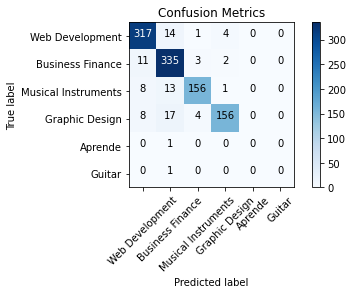

In [83]:
plot_cm(cm, classe_names)

In [85]:
print(classification_report(yTrue, yPred, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       336
         1.0       0.88      0.95      0.92       351
         2.0       0.95      0.88      0.91       178
         3.0       0.96      0.84      0.90       185
         5.0       1.00      0.00      0.00         1
         8.0       1.00      0.00      0.00         1

    accuracy                           0.92      1052
   macro avg       0.95      0.60      0.61      1052
weighted avg       0.92      0.92      0.92      1052



In [86]:
print(classification_report(yTrue, 
                            yPred, 
                            target_names= classe_names, 
                            zero_division=1))

                     precision    recall  f1-score   support

    Web Development       0.92      0.94      0.93       336
   Business Finance       0.88      0.95      0.92       351
Musical Instruments       0.95      0.88      0.91       178
     Graphic Design       0.96      0.84      0.90       185
            Aprende       1.00      0.00      0.00         1
             Guitar       1.00      0.00      0.00         1

           accuracy                           0.92      1052
          macro avg       0.95      0.60      0.61      1052
       weighted avg       0.92      0.92      0.92      1052



In [90]:
new_entry = spark.createDataFrame(
    [('Learn Power BI and Build a great report dashboard', StringType())],
    ['course_title'])

In [91]:
new_entry.show(truncate= False)

+-------------------------------------------------+---+
|course_title                                     |_2 |
+-------------------------------------------------+---+
|Learn Power BI and Build a great report dashboard|[] |
+-------------------------------------------------+---+



In [92]:
pred_new_entry = lr_model.transform(new_entry)

In [95]:
pred_new_entry.limit(1).toPandas()

,course_title,_2,tokens,stp_tokens,vectors,vectorized,rawPrediction,probability,prediction
0,Learn Power BI and Build a great report dashboard,(),"[learn, power, bi, and, build, a, great, repor...","[learn, power, bi, build, great, report, dashb...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.9701374443906376, 0.0, 0.0, 0.0, 0.0, ...","[10.15697570890937, 11.744077531834709, -2.337...","[0.16979144266393575, 0.8302050338106395, 6.36...",1.0


In [96]:
print(pred_new_entry.columns)

['course_title', '_2', 'tokens', 'stp_tokens', 'vectors', 'vectorized', 'rawPrediction', 'probability', 'prediction']


In [97]:
pred_new_entry.select('course_title', 'rawPrediction', 'probability', 'prediction').show()

+--------------------+--------------------+--------------------+----------+
|        course_title|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|Learn Power BI an...|[10.1569757089093...|[0.16979144266393...|       1.0|
+--------------------+--------------------+--------------------+----------+



In [98]:
lbl_dict

{'Web Development': 0.0,
 'Business Finance': 1.0,
 'Musical Instruments': 2.0,
 'Graphic Design': 3.0,
 'Aprende tocar el Acorden de odo con tcnicahttpswwwudemycomaprendeatocarelacordeondeoidoycontecnicatrue25932134Beginner Level4 hours20140916T195145Z 263432Aprende los Secretos de la Armnica con HARPSOUL': 4.0,
 'Introduction Guitar A Course Beginnershttpswwwudemycomintroductiontoguitartrue251631156Beginner Level25 hours20141030T155939Z 650804Guitar Master Class Learning Play Guitar Z': 5.0,
 'Learn Classical Guitar Technique play Spanish Romancehttpswwwudemycomguitartechniquestrue19513164643All Levels5 hours20131118T175959Z 265888Learn Guitar Worship Learn 4 Songs unlock 1': 6.0,
 'Learn Play Fernando Sors Study B minorhttpswwwudemycomstudyinbminortrue115140359Intermediate Level43 mins20140127T205816Z 398746Piano Chord Based System  Learn Play Pros Do': 7.0,
 'Multiply returns Value Investinghttpswwwudemycommultiplyyourreturnsusingvalueinvestingtrue2019421963All Levels45 hours201507

In [102]:
new_input = spark.createDataFrame(
    [('Solfege basis with piano and guitar', StringType())],
    ['course_title'])
pred_new_input = lr_model.transform(new_input)
pred_new_input.limit(1).toPandas()
pred_new_input.select('course_title', 'rawPrediction', 'probability', 'prediction').show()

+--------------------+--------------------+--------------------+----------+
|        course_title|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|Solfege basis wit...|[-6.6904170836096...|[5.49800190275741...|       2.0|
+--------------------+--------------------+--------------------+----------+



In [108]:
new_input = spark.createDataFrame(
    [('responsive android phone', StringType())],
    ['course_title'])
pred_new_input = lr_model.transform(new_input)
pred_new_input.limit(1).toPandas()
pred_new_input.select('course_title', 'rawPrediction', 'probability', 'prediction').show()

+--------------------+--------------------+--------------------+----------+
|        course_title|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|responsive androi...|[8.04946274809401...|[0.90243655634433...|       0.0|
+--------------------+--------------------+--------------------+----------+

